## 1.Intro:
This notebook is a very basic and simple introductory primer to the method of ensembling (combining) base learning models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level (base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions.

The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.

In [52]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
import plotly.plotly as py1

In [30]:
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

### Feature Exploration, Engineering and Cleaning

In [19]:
# Load in the train and test datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [21]:
full_data = [train, test]

#名字长度
# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

#有没有cabin
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#家庭规模
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
#新特征：费用等级
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']       = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

C:\Users\tianjiayang\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [23]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


In [24]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


## Pearson Correlation Heatmap

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

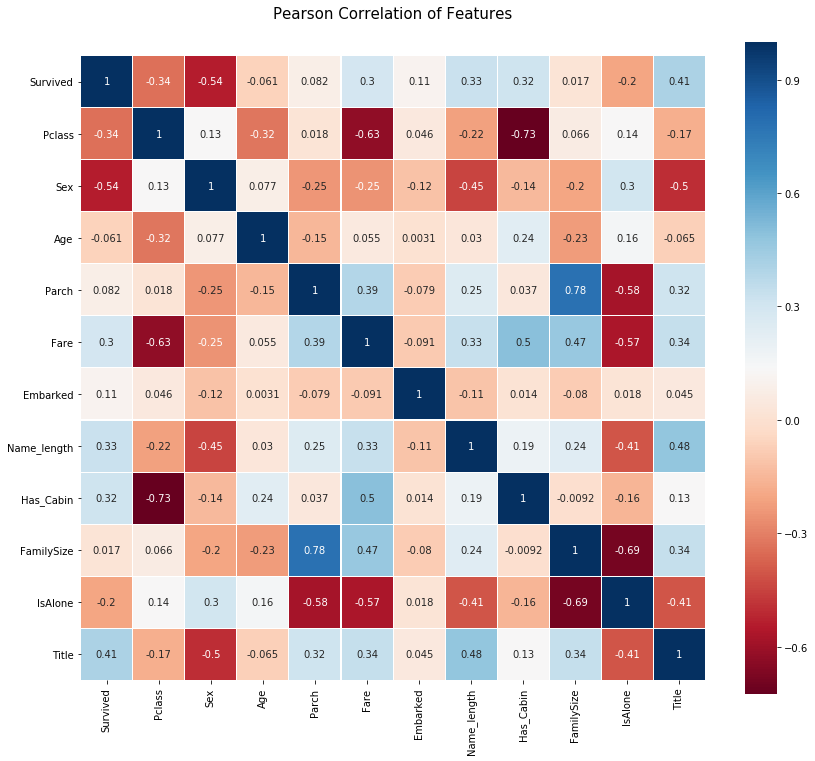

In [25]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.

C:\Users\tianjiayang\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\tianjiayang\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


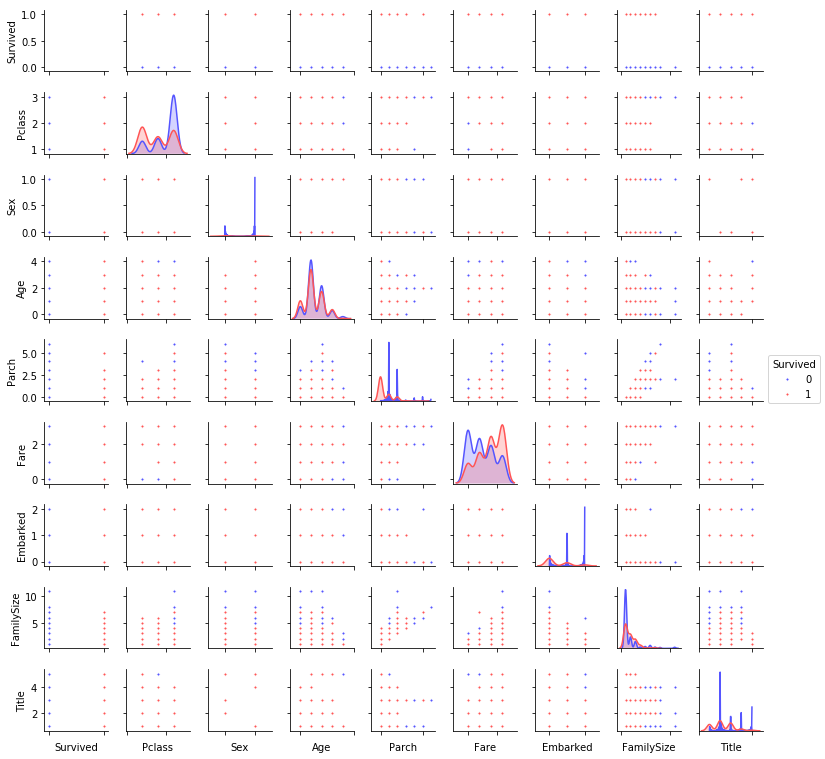

In [26]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Models

In [31]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

Titanic 栗子：

Train Data有890行。(请对应图中的上层部分）

每1次的fold，都会生成 713行 小train， 178行 小test。我们用Model 1来训练 713行的小train，然后预测 178行 小test。预测的结果是长度为 178 的预测值。

这样的动作走5次！ 长度为178 的预测值 X 5 = 890 预测值，刚好和Train data长度吻合。这个890预测值是Model 1产生的，我们先存着，因为，一会让它将是第二层模型的训练来源。

重点：这一步产生的预测值我们可以转成 890 X 1 （890 行，1列），记作 P1 (大写P)

接着说 Test Data 有 418 行。(请对应图中的下层部分，对对对，绿绿的那些框框）

每1次的fold，713行 小train训练出来的Model 1要去预测我们全部的Test Data（全部！因为Test Data没有加入5-fold，所以每次都是全部！）。此时，Model 1的预测结果是长度为418的预测值。

这样的动作走5次！我们可以得到一个 5 X 418 的预测值矩阵。然后我们根据行来就平均值，最后得到一个 1 X 418 的平均预测值。

重点：这一步产生的预测值我们可以转成 418 X 1 （418行，1列），记作 p1 (小写p)

走到这里，你的第一层的Model 1完成了它的使命。

第一层还会有其他Model的，比如Model 2，同样的走一遍， 我们有可以得到  890 X 1  (P2) 和  418 X 1 (p2) 列预测值。

这样吧，假设你第一层有3个模型，这样你就会得到：

来自5-fold的预测值矩阵 890 X 3，（P1，P2， P3）  和 来自Test Data预测值矩阵 418 X 3， （p1, p2, p3）。

-----------------------------------------

到第二层了..................

来自5-fold的预测值矩阵 890 X 3 作为你的Train Data，训练第二层的模型
来自Test Data预测值矩阵 418 X 3 就是你的Test Data，用训练好的模型来预测他们吧。

In [32]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models 

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine
 6. Logsitic Regression

In [38]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

lr_params = {
    'penalty':'l2',
    'C':0.025
    
}

 let us now create 5 objects that represent our 5 learning models via our Helper

In [39]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

### **Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [55]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12349574 0.19832009 0.03325595 0.02133891 0.07158793 0.02395915
 0.10726297 0.06666811 0.06608496 0.01373773 0.27428846]
[0.11808146 0.38037963 0.02873431 0.01691062 0.05720914 0.02924952
 0.0453527  0.08377124 0.04326961 0.02173523 0.17530654]
[0.03  0.01  0.012 0.07  0.042 0.01  0.696 0.014 0.046 0.004 0.066]
[0.07929993 0.03723021 0.07827649 0.02994626 0.09430579 0.05364191
 0.41178733 0.02049216 0.07607014 0.02324469 0.0957051 ]


In [64]:
rf_features = [0.12349574, 0.19832009, 0.03325595, 0.02133891, 0.07158793, 0.02395915,
 0.10726297, 0.06666811, 0.06608496, 0.01373773, 0.27428846]
et_features = [0.11808146, 0.38037963, 0.02873431, 0.01691062, 0.05720914, 0.02924952,
 0.0453527,  0.08377124, 0.04326961, 0.02173523, 0.17530654]
ada_features = [0.03,  0.01,  0.012, 0.07,  0.042, 0.01,  0.696, 0.014, 0.046, 0.004, 0.066]
gb_features = [0.07929993, 0.03723021, 0.07827649, 0.02994626, 0.09430579, 0.05364191,
 0.41178733, 0.02049216, 0.07607014, 0.02324469, 0.0957051 ]

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

In [66]:
# Create the new column containing the average of values
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.123496,0.118081,0.030,0.079300,0.087719
1,Sex,0.198320,0.380380,0.010,0.037230,0.156482
2,Age,0.033256,0.028734,0.012,0.078276,0.038067


### Second-Level Predictions from the First-level Output

First-level output as new features

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [68]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [71]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [76]:
x_train

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

In [72]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [75]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.